## Load dependencies

In [3]:
import time
from datetime import timedelta

from matplotlib import pyplot as plt
# from torch.utils.data import DataLoader
# from torch.optim import Adam, lr_scheduler

from unet.new_unet import UNet
from unet.ml_models import UNetTunable
from unet.ml_trainer import SetupTrainer
from unet.ml_criterions import FocalTverskyLoss
from unet.ml_metrics import IoUCoeff
from unet.ml_dataset import UNetDataset, split_dataset, create_dataloaders, compute_mean_std

ModuleNotFoundError: No module named 'unet'

## Define all parameters

In [3]:
# model
IN_CHANNELS = 1
OUT_CLASSES = 1
DEPTH=4
FILTERS=3

DILATION=2
DROPOUT=True

UPMODE='upsample'

ATTENTION_BLOCK=True



# Data
VALID_SIZE = 0.2
BATCH_SIZE = 8
AUGMENT = False
# Mean and std values are calculated based
# on benchmark_version3.hdf5
# MEAN = [0.6735]
# STD = [0.1342]

MEAN = [0.67709]
STD = [0.13369]

NUM_WORKERS = 0

# Optimizer
LEARN_RATE = 0.001

# Scheduler
LR_STEP_SIZE = 10
LR_DECAY_RATE = 0.1

# Loss function
ALPHA = 0.3
BETA = 0.7
GAMMA = 0.75

# Other hyperparameters
MAX_EPOCHS = 5
EARLY_STOP_PATIENCE = 10
MIN_CKP_ACC = 0.5

NUM_SAMPLES = None  # can be used for testing
USE_CUDA = True
PATH_OUT = "experiments"
TENSORBOARD = True

## Data paths

In [8]:
png_path = r"C:\Raghava_local\GITLAB\SemanticSegmentor\data\training_testing_set\training"

## Compute mean and std
- only if necessary

In [9]:
# mean, std = compute_mean_std(hdf5_path)
# MEAN = [mean]
# STD = [std]

## Create dataset objects

In [10]:
unet_dataset = UNetDataset.from_png_files(png_path, 
                                          augment=AUGMENT,
                                          mean=MEAN, 
                                          std=STD, 
                                          num_samples=NUM_SAMPLES)

data_dict = split_dataset(unet_dataset, VALID_SIZE)

print(data_dict["train"].__len__())
print(data_dict["valid"].__len__())

800
200


## Visualize data samples

Image shape: torch.Size([1, 80, 250])
Mask shape: torch.Size([80, 250])
Image range: [-5.064627170562744,2.4153640270233154]
Mask range: [0.0,1.0]


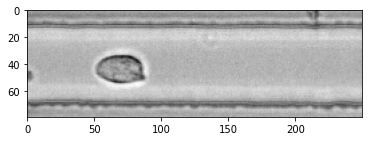

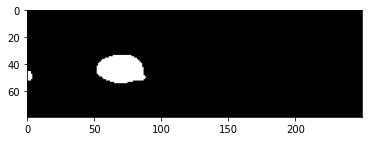

Image shape: torch.Size([1, 80, 250])
Mask shape: torch.Size([80, 250])
Image range: [-5.064627170562744,2.4153640270233154]
Mask range: [0.0,1.0]


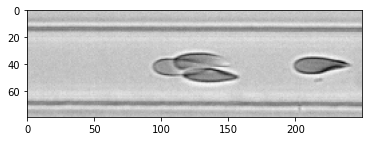

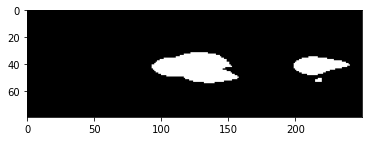

In [11]:
tds = data_dict["train"]
for i in range(2):
    img, msk = tds.__getitem__(i)
    print("Image shape:", img.shape)
    print("Mask shape:", msk.shape)
    print("Image range: [{},{}]".format(img.min(), img.max()))
    print("Mask range: [{},{}]".format(msk.min(), msk.max()))

    plt.imshow(img.permute(1, 2, 0), "gray")
    plt.show()
    plt.imshow(msk, "gray")
    plt.show()

## Create data loaders

In [12]:
dataloaders = create_dataloaders(data_dict, BATCH_SIZE, NUM_WORKERS)

In [13]:
print(len(dataloaders["train"].dataset))
print(len(dataloaders["valid"].dataset))

800
200


## Create model

In [9]:
# unet_model = UNetTunable(in_channels=IN_CHANNELS,
#                          out_classes=OUT_CLASSES,
#                          depth=DEPTH, 
#                          filters=FILTERS,
#                          dilation=DILATION, 
#                          dropout=DROPOUT,
#                          up_mode=UPMODE,
#                          with_attn=ATTENTION_BLOCK)


In [37]:
unet_model = UNet(in_channels=1, out_channels=1, init_features=32).cuda()

In [40]:
dataiter = iter(dataloaders["train"])
images, labels = next(dataiter)
img = images.to(device, dtype=torch.float32)
r = unet_model(img)
r.shape

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 30 but got size 31 for tensor number 1 in the list.

In [15]:
ckp_path = r"C:\Users\ralajan\.cache\torch\hub\checkpoints\unet-e012d006.pt"

In [17]:
import torch
device = torch.device("cuda" if USE_CUDA else "cpu")
ckp = torch.load(ckp_path, map_location=device)

In [26]:
# ckp.keys()

In [22]:
state_dict = unet_model.state_dict()

In [24]:
for key, value in ckp.items():
    if "encoder1" in key or "decoder1" in key:
        pass
    else:
        state_dict[key] = value

In [25]:
unet_model.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
for param in unet_model.parameters():
    param.requires_grad = False


In [28]:
unet_model.encoder1.requires_grad = True
unet_model.decoder1.requires_grad = True

## Create criterion and metric

In [29]:
criterion = FocalTverskyLoss(alpha=ALPHA, beta=BETA, gamma=GAMMA)

metric = IoUCoeff()

## Create optimizer and scheduler

In [30]:
optimizer = Adam(unet_model.parameters(), lr=LEARN_RATE)

scheduler = lr_scheduler.StepLR(optimizer=optimizer,
                                step_size=LR_STEP_SIZE,
                                gamma=LR_DECAY_RATE)

## Set the trainer

In [31]:
trainer = SetupTrainer(model=unet_model,
                       dataloaders=dataloaders,
                       criterion=criterion,
                       metric=metric,
                       optimizer=optimizer,
                       scheduler=scheduler,
                       max_epochs=MAX_EPOCHS,
                       use_cuda=USE_CUDA,
                       min_ckp_acc=MIN_CKP_ACC,
                       early_stop_patience=EARLY_STOP_PATIENCE,
                       path_out=PATH_OUT,
                       tensorboard=TENSORBOARD,
                       init_from_ckp=None
                       )


Trainable parameters in the model: 0.0


## Start Training

In [32]:
tik = time.time()
print("Started training.....")
trainer.start_train()
tok = time.time() - tik
train_time = str(timedelta(seconds=tok)).split('.')[0]
print(f"Total training time: {train_time}")

Started training.....


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 30 but got size 31 for tensor number 1 in the list.